<a href="https://colab.research.google.com/github/costpetrides/FAIRMODE-WG5/blob/main/Python/IDW_exp_PM25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install netCDF4

In [2]:
pip install cartopy

# IDW - Additive Method

In [4]:
import numpy as np
import pandas as pd
import netCDF4 as nc
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import itertools
from sklearn.neighbors import BallTree

# === Load CSV Data ===
csv_file_path = "basePM25nearest_grid.csv"
df = pd.read_csv(csv_file_path)

# Compute bias (Observed - Modeled)
df["bias"] = df["SURF_ug_PM25_rh50"] - df["nearest_SURF_ug_PM25_rh50"]

# === Load NetCDF Data ===
netcdf_path = "BaseCase_PERT_PM25_rh50_YEARLY.nc"
dataset = nc.Dataset(netcdf_path, "r")

lon = dataset.variables["lon"][:]
lat = dataset.variables["lat"][:]
pm25_modeled = dataset.variables["SURF_ug_PM25_rh50"][0, :, :]

# Convert degrees to radians (for Haversine calculations)
lon_rad = np.radians(lon)
lat_rad = np.radians(lat)

# Create Meshgrid for Grid Points
lon_mesh, lat_mesh = np.meshgrid(lon_rad, lat_rad)
points_grid = np.column_stack([lat_mesh.ravel(), lon_mesh.ravel()])

# Prepare Station Data (Convert to Radians)
station_lons_rad = np.radians(df["nearest_grid_lon"].values)
station_lats_rad = np.radians(df["nearest_grid_lat"].values)
station_points = np.column_stack([station_lats_rad, station_lons_rad])
bias_values = df["bias"].values

# === Define Hyperparameter Search Range for `p` and `k` ===
p_values = np.arange(0.1, 5.1, 0.1).tolist()  # p (Decay Rate)
k_values = np.arange(2, 41, 1).tolist()  # k (Number of Neighbors)

# === Perform Grid Search ===
kf = KFold(n_splits=10, shuffle=True, random_state=42)
results = []
best_rmse = float("inf")
best_params = None

with tqdm(total=len(p_values) * len(k_values), desc="Grid Search for Exponential IDW") as pbar:
    for p, k in itertools.product(p_values, k_values):
        fold_rmses = []

        for train_index, test_index in kf.split(station_points):
            train_points, test_points = station_points[train_index], station_points[test_index]
            train_values, test_values = bias_values[train_index], bias_values[test_index]

            train_tree = BallTree(train_points, metric="haversine")
            predicted_bias = []

            for test_point in test_points:
                dists, idxs = train_tree.query([test_point], k=k)

                dists = dists.flatten()
                idxs = idxs.flatten()

                if np.any(dists == 0):  # Exact match case
                    predicted_bias.append(train_values[idxs[dists == 0]][0])
                else:
                    weights = np.exp(-p * dists)  # Exponential Decay Weighting
                    interpolated_bias = np.sum(weights * train_values[idxs]) / np.sum(weights)
                    predicted_bias.append(interpolated_bias)

            fold_rmse = np.sqrt(mean_squared_error(test_values, predicted_bias))
            fold_rmses.append(fold_rmse)

        mean_rmse = np.mean(fold_rmses)
        results.append((p, k, mean_rmse))

        if mean_rmse < best_rmse:
            best_rmse = mean_rmse
            best_params = (p, k)

        pbar.update(1)

# Save Grid Search Results
results_df = pd.DataFrame(results, columns=["p", "k", "RMSE"])
results_df.to_csv("BaseCase_PM25_rh50_Y_IDW_EXP_add_Val.csv", index=False)

print(f"\n Best parameters found: p={best_params[0]}, k={best_params[1]} with RMSE={best_rmse:.4f}")

# === Apply IDW with Optimized `p` and `k` ===
def idw_exponential(grid_points, station_points, values, p, k):
    station_tree = BallTree(station_points, metric="haversine")
    dists, idxs = station_tree.query(grid_points, k=k)

    zero_dist_mask = dists == 0
    interpolated = np.zeros(grid_points.shape[0])

    interpolated[zero_dist_mask[:, 0]] = values[idxs[zero_dist_mask[:, 0], 0]]

    non_zero_idx = ~zero_dist_mask[:, 0]
    dists_non_zero = dists[non_zero_idx]
    idxs_non_zero = idxs[non_zero_idx]

    weights = np.exp(-p * dists_non_zero)
    weights /= np.sum(weights, axis=1, keepdims=True)

    interpolated[non_zero_idx] = np.sum(weights * values[idxs_non_zero], axis=1)

    return interpolated

# Interpolate Bias with Best Hyperparameters
print("\n Applying Exponential Decay IDW with Optimized p & k...")
interpolated_bias_exp = idw_exponential(points_grid, station_points, bias_values, best_params[0], best_params[1])
interpolated_bias_exp = interpolated_bias_exp.reshape(pm25_modeled.shape)

# === Save Bias Interpolation to NetCDF ===
bias_netcdf_path = "BaseCase_PM25_rh50_Y_IDW_EXP_add.nc"

new_dataset = nc.Dataset(bias_netcdf_path, "w", format="NETCDF4")
new_dataset.createDimension("lat", lat.shape[0])
new_dataset.createDimension("lon", lon.shape[0])
lat_var = new_dataset.createVariable("lat", "f4", ("lat",))
lon_var = new_dataset.createVariable("lon", "f4", ("lon",))
bias_var = new_dataset.createVariable("Interpolated_Bias", "f4", ("lat", "lon"))

bias_var.setncatts(dataset.variables["SURF_ug_PM25_rh50"].__dict__)
new_dataset.description = "Interpolated Bias using Exponential Decay IDW (Optimized p & k, No Time Dimension, Haversine BallTree)"

lat_var[:] = lat
lon_var[:] = lon
bias_var[:, :] = interpolated_bias_exp

new_dataset.close()
print(" Interpolated Bias Saved to:", bias_netcdf_path)


Grid Search for Exponential IDW: 100%|██████████| 1950/1950 [14:21<00:00,  2.26it/s]



 Best parameters found: p=5.0, k=3 with RMSE=0.5410

 Applying Exponential Decay IDW with Optimized p & k...
 Interpolated Bias Saved to: BaseCase_PM25_rh50_Y_IDW_EXP_add.nc


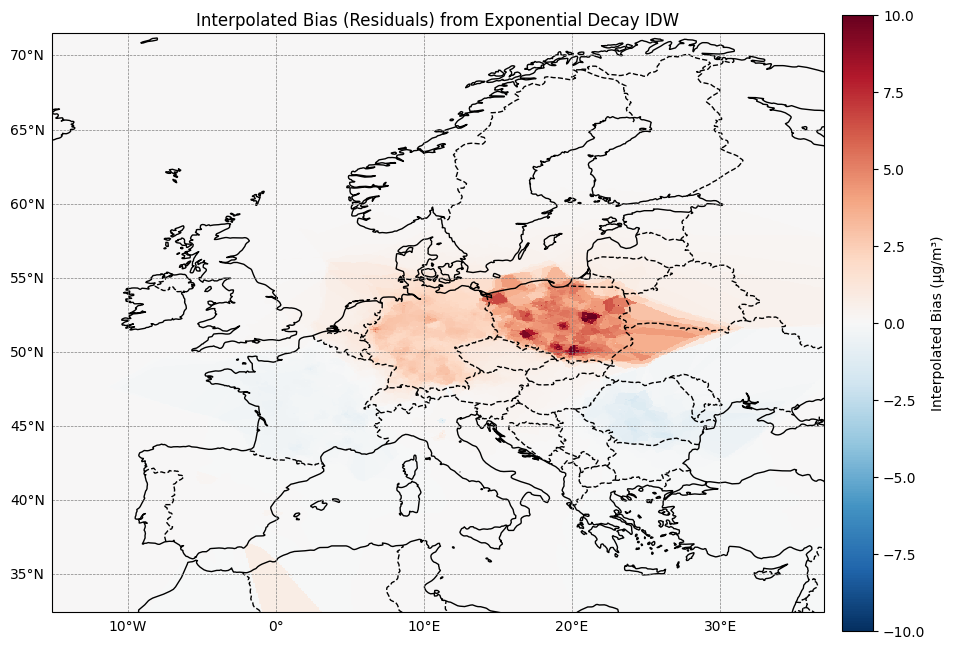

In [35]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# === Load the Interpolated Bias NetCDF File ===
bias_netcdf_path = "Add/BaseCase_PM25_rh50_Y_IDW_EXP_add.nc"
ds_bias = xr.open_dataset(bias_netcdf_path)

# Extract interpolated bias (residuals)
interpolated_bias = ds_bias["Interpolated_Bias"].squeeze().values

# Extract coordinates
lon = ds_bias["lon"].values
lat = ds_bias["lat"].values

# === Define Plot Limits (Adjust if needed) ===
cbar_min = -10  # Minimum bias value for color scale
cbar_max = 10  # Maximum bias value for color scale

# Create a plot with Cartopy
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the interpolated bias
im = ax.pcolormesh(lon, lat, interpolated_bias, transform=ccrs.PlateCarree(), cmap="RdBu_r", vmin=cbar_min, vmax=cbar_max, shading='auto')

# Add colorbar
cbar = plt.colorbar(im, orientation="vertical", pad=0.02)
cbar.set_label("Interpolated Bias (µg/m³)")

# Add country borders and coastlines
ax.add_feature(cfeature.BORDERS, linestyle="--", edgecolor="black", linewidth=1)
ax.coastlines(resolution="50m", linewidth=1)

# Add gridlines and labels for longitude and latitude
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Remove top labels
gl.right_labels = False  # Remove right-side labels

# Set title and labels
plt.title("Interpolated Bias (Residuals) from Exponential Decay IDW")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()

# Close dataset
ds_bias.close()

In [8]:
import netCDF4 as nc
import numpy as np

# === Define File Paths ===
original_nc_path = "BaseCase_PERT_PM25_rh50_YEARLY.nc"
bias_nc_path = "Add/BaseCase_PM25_rh50_Y_IDW_EXP_add.nc"
corrected_nc_path = "Add/BaseCase_Corrected_PM25_rh50_Y_EXP_add.nc"

# === Load the Original Modeled PM₂.₅ NetCDF ===
with nc.Dataset(original_nc_path, "r") as original_nc, nc.Dataset(bias_nc_path, "r") as bias_nc:

    # Load model coordinates and data
    lon = original_nc.variables["lon"][:]
    lat = original_nc.variables["lat"][:]
    time = original_nc.variables["time"][:]
    pm25_original = original_nc.variables["SURF_ug_PM25_rh50"][:]

    # Load the interpolated bias
    interpolated_bias = bias_nc.variables["Interpolated_Bias"][:]

    # === Compute the Unbiased PM₂.₅ ===
    pm25_corrected = pm25_original + interpolated_bias  # Apply the bias correction

    # === Save the Corrected PM₂.₅ to a New NetCDF File ===
    with nc.Dataset(corrected_nc_path, "w", format="NETCDF4") as new_nc:

        # Create dimensions
        new_nc.createDimension("time", None)
        new_nc.createDimension("lat", lat.shape[0])
        new_nc.createDimension("lon", lon.shape[0])

        # Create variables
        time_var = new_nc.createVariable("time", "f4", ("time",))
        lat_var = new_nc.createVariable("lat", "f4", ("lat",))
        lon_var = new_nc.createVariable("lon", "f4", ("lon",))
        pm25_var = new_nc.createVariable("SURF_ug_PM25_rh50_corrected", "f4", ("time", "lat", "lon"), fill_value=-9999.0)

        # Copy attributes from the original PM₂.₅ variable
        pm25_var.setncatts(original_nc.variables["SURF_ug_PM25_rh50"].__dict__)

        # Save data
        time_var[:] = time
        lat_var[:] = lat
        lon_var[:] = lon
        pm25_var[:] = pm25_corrected  # Store corrected PM₂.₅

print(" Bias correction completed successfully!")
print(" Corrected PM₂.₅ NetCDF file saved as:", corrected_nc_path)


 Bias correction completed successfully!
 Corrected PM₂.₅ NetCDF file saved as: Add/BaseCase_Corrected_PM25_rh50_Y_EXP_add.nc


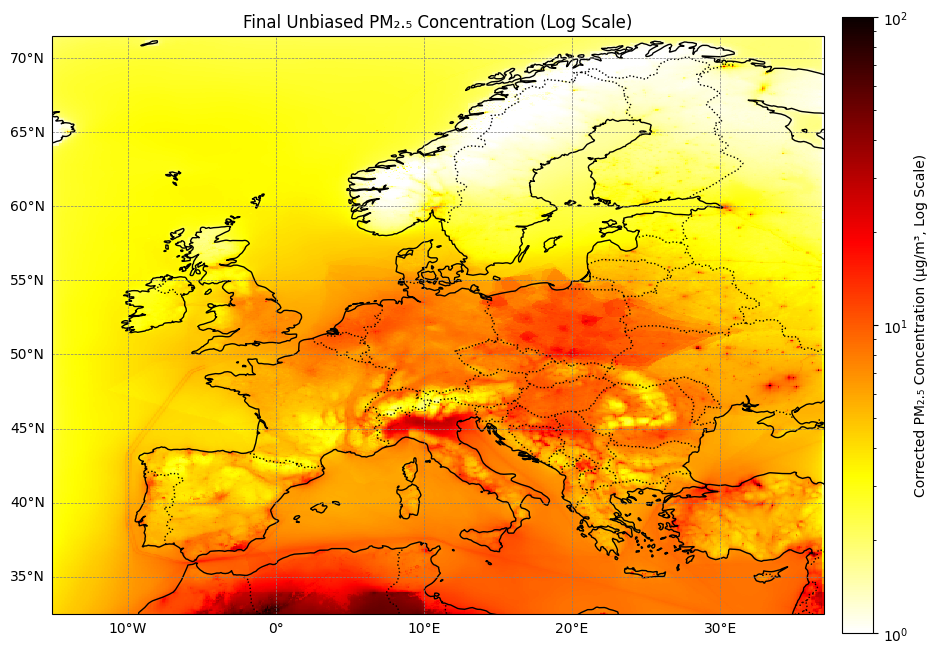

In [15]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import numpy as np

# === Load the Corrected PM₂.₅ NetCDF File ===
corrected_netcdf_path = "Add/BaseCase_Corrected_PM25_rh50_Y_EXP_add.nc"
ds_corrected = xr.open_dataset(corrected_netcdf_path)

# Extract corrected PM₂.₅ values
corrected_pm25 = ds_corrected["SURF_ug_PM25_rh50_corrected"].squeeze().values

# Extract coordinates
lon = ds_corrected["lon"].values
lat = ds_corrected["lat"].values

# Create a 2D meshgrid for lon & lat
Lon, Lat = np.meshgrid(lon, lat)

# === Define Logarithmic Scale for Color Normalization ===
norm = mcolors.LogNorm(vmin=1, vmax=100)  # Log scale between 1 and max value

# Create a figure with a map projection
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the PM₂.₅ concentration using pcolormesh with logarithmic scaling
mesh = ax.pcolormesh(Lon, Lat, corrected_pm25, cmap='hot_r', shading='auto', transform=ccrs.PlateCarree(), norm=norm)

# Add a colorbar with logarithmic scaling
cbar = plt.colorbar(mesh, orientation="vertical", pad=0.02)
cbar.set_label("Corrected PM₂.₅ Concentration (µg/m³, Log Scale)")

# Add coastlines and borders for context
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Add gridlines and labels for longitude and latitude
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Remove top labels
gl.right_labels = False  # Remove right-side labels

# Set title and labels
plt.title("Final Unbiased PM₂.₅ Concentration (Log Scale)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()

# Close dataset
ds_corrected.close()


# IDW- Multiplicative Mehod

In [16]:
import numpy as np
import pandas as pd
import netCDF4 as nc
from sklearn.neighbors import BallTree
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import itertools

# === Load CSV Data ===
csv_file_path = "basePM25nearest_grid.csv"
df = pd.read_csv(csv_file_path)

# Compute bias ratio (Observed / Modeled)
df["bias_ratio"] = df["SURF_ug_PM25_rh50"] / df["nearest_SURF_ug_PM25_rh50"]

# === Load NetCDF Data ===
netcdf_path = "BaseCase_PERT_PM25_rh50_YEARLY.nc"
dataset = nc.Dataset(netcdf_path, "r")

lon = dataset.variables["lon"][:]
lat = dataset.variables["lat"][:]
pm25_modeled = dataset.variables["SURF_ug_PM25_rh50"][0, :, :]

# Create Meshgrid for Grid Points
lon_mesh, lat_mesh = np.meshgrid(lon, lat)
points_grid = np.column_stack([np.radians(lat_mesh.ravel()), np.radians(lon_mesh.ravel())])  # Convert to radians for BallTree

# Prepare Station Data
station_points = np.column_stack([np.radians(df["nearest_grid_lat"].values), np.radians(df["nearest_grid_lon"].values)])  # Convert to radians
bias_ratios = df["bias_ratio"].values

# === Define Hyperparameter Search Range for `p` and `k` ===
p_values = np.arange(0.1, 5.1, 0.1).tolist()  # p (Decay Rate)
k_values = np.arange(2, 41, 1).tolist()  # k (Number of Neighbors)

# === Perform Grid Search ===
kf = KFold(n_splits=10, shuffle=True, random_state=42)
results = []
best_rmse = float("inf")
best_params = None

with tqdm(total=len(p_values) * len(k_values), desc="Grid Search for Exponential IDW Multiplicative (BallTree)") as pbar:
    for p, k in itertools.product(p_values, k_values):
        fold_rmses = []

        for train_index, test_index in kf.split(station_points):
            train_points, test_points = station_points[train_index], station_points[test_index]
            train_values, test_values = bias_ratios[train_index], bias_ratios[test_index]

            train_tree = BallTree(train_points, metric="haversine")  # Use BallTree with Haversine distance
            dists, idxs = train_tree.query(test_points, k=k)

            predicted_bias_ratio = []
            for i in range(len(test_points)):
                if np.any(dists[i] == 0):
                    predicted_bias_ratio.append(train_values[idxs[i][dists[i] == 0]][0])
                else:
                    weights = np.exp(-p * dists[i])  # Exponential Decay Weighting
                    interpolated_ratio = np.sum(weights * train_values[idxs[i]]) / np.sum(weights)
                    predicted_bias_ratio.append(interpolated_ratio)

            fold_rmse = np.sqrt(mean_squared_error(test_values, predicted_bias_ratio))
            fold_rmses.append(fold_rmse)

        mean_rmse = np.mean(fold_rmses)
        results.append((p, k, mean_rmse))

        if mean_rmse < best_rmse:
            best_rmse = mean_rmse
            best_params = (p, k)

        pbar.update(1)

# Save Grid Search Results
results_df = pd.DataFrame(results, columns=["p", "k", "RMSE"])
results_df.to_csv("BaseCase_PM25_rh50_Y_IDW_EXP_MUL_Val.csv", index=False)

print(f"\n Best parameters found: p={best_params[0]}, k={best_params[1]} with RMSE={best_rmse:.4f}")

# === Apply IDW Multiplicative with Optimized `p` and `k` ===
def idw_multiplicative(grid_points, station_points, values, p, k):
    station_tree = BallTree(station_points, metric="haversine")  # Use BallTree with Haversine distance
    dists, idxs = station_tree.query(grid_points, k=k)

    zero_dist_mask = dists == 0
    interpolated = np.ones(grid_points.shape[0])  # Initialize with 1 (Multiplicative method)

    interpolated[zero_dist_mask[:, 0]] = values[idxs[zero_dist_mask[:, 0], 0]]

    non_zero_idx = ~zero_dist_mask[:, 0]
    dists_non_zero = dists[non_zero_idx]
    idxs_non_zero = idxs[non_zero_idx]

    weights = np.exp(-p * dists_non_zero)
    weights /= np.sum(weights, axis=1, keepdims=True)

    interpolated[non_zero_idx] = np.sum(weights * values[idxs_non_zero], axis=1)

    return interpolated

# Interpolate Bias Ratio with Best Hyperparameters
print("\n Applying Exponential Decay IDW Multiplicative with Optimized p & k (BallTree)...")
interpolated_ratio_exp = idw_multiplicative(points_grid, station_points, bias_ratios, best_params[0], best_params[1])
interpolated_ratio_exp = interpolated_ratio_exp.reshape(pm25_modeled.shape)

# === Save Bias Ratio Interpolation to NetCDF ===
bias_netcdf_path = "BaseCase_PM25_rh50_Y_IDW_EXP_MUL.nc"

new_dataset = nc.Dataset(bias_netcdf_path, "w", format="NETCDF4")
new_dataset.createDimension("lat", lat.shape[0])
new_dataset.createDimension("lon", lon.shape[0])
lat_var = new_dataset.createVariable("lat", "f4", ("lat",))
lon_var = new_dataset.createVariable("lon", "f4", ("lon",))
bias_ratio_var = new_dataset.createVariable("Interpolated_Bias_Ratio", "f4", ("lat", "lon"))

bias_ratio_var.setncatts(dataset.variables["SURF_ug_PM25_rh50"].__dict__)
new_dataset.description = "Interpolated Bias Ratio using Exponential Decay IDW Multiplicative (Optimized p & k, No Time Dimension, BallTree with Haversine)"

lat_var[:] = lat
lon_var[:] = lon
bias_ratio_var[:, :] = interpolated_ratio_exp

new_dataset.close()
print("Interpolated Bias Ratio Saved to:", bias_netcdf_path)


Grid Search for Exponential IDW Multiplicative (BallTree): 100%|██████████| 1950/1950 [05:47<00:00,  5.61it/s]



 Best parameters found: p=5.0, k=4 with RMSE=0.0579

 Applying Exponential Decay IDW Multiplicative with Optimized p & k (BallTree)...
Interpolated Bias Ratio Saved to: BaseCase_PM25_rh50_Y_IDW_EXP_MUL.nc


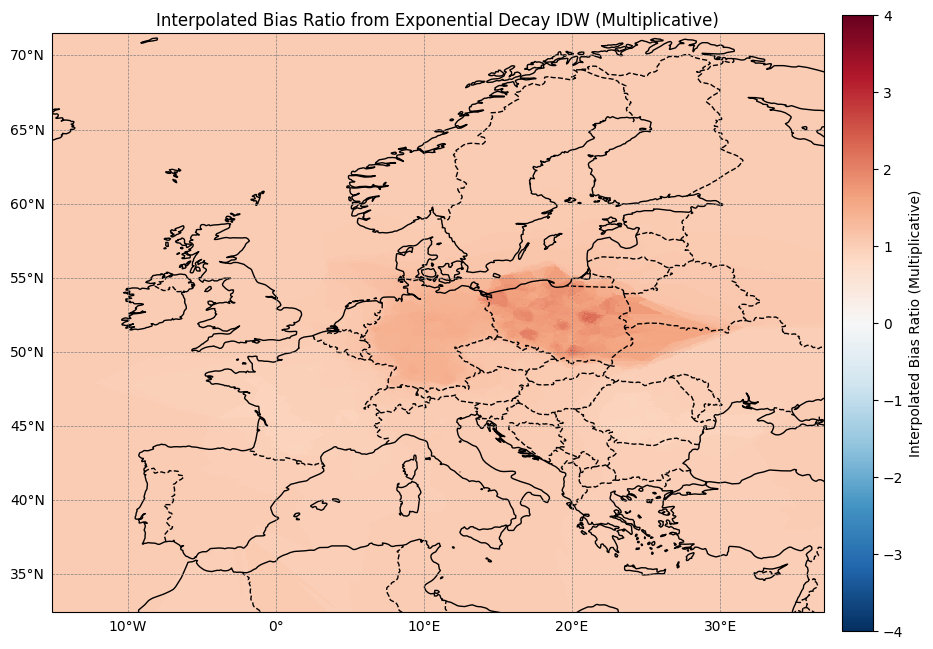

In [31]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# === Load the Interpolated Bias Ratio NetCDF File ===
bias_netcdf_path = "Mul/BaseCase_PM25_rh50_Y_IDW_EXP_MUL.nc"
ds_bias = xr.open_dataset(bias_netcdf_path)

# Extract interpolated bias ratio
interpolated_bias_ratio = ds_bias["Interpolated_Bias_Ratio"].squeeze().values

# Extract coordinates
lon = ds_bias["lon"].values
lat = ds_bias["lat"].values

# === Define Plot Limits (Adjust if needed) ===
cbar_min = -4 # Set minimum scale for bias ratio
cbar_max = 4  # Set maximum scale for bias ratio

# Create a plot with Cartopy
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the interpolated bias ratio
im = ax.pcolormesh(lon, lat, interpolated_bias_ratio, transform=ccrs.PlateCarree(), cmap="RdBu_r", vmin=cbar_min, vmax=cbar_max, shading='auto')

# Add colorbar
cbar = plt.colorbar(im, orientation="vertical", pad=0.02)
cbar.set_label("Interpolated Bias Ratio (Multiplicative)")

# Add country borders and coastlines
ax.add_feature(cfeature.BORDERS, linestyle="--", edgecolor="black", linewidth=1)
ax.coastlines(resolution="50m", linewidth=1)

# Add gridlines and labels for longitude and latitude
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Remove top labels
gl.right_labels = False  # Remove right-side labels

# Set title and labels
plt.title("Interpolated Bias Ratio from Exponential Decay IDW (Multiplicative)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()

# Close dataset
ds_bias.close()


In [28]:
import netCDF4 as nc
import numpy as np

# === Define File Paths ===
original_nc_path = "BaseCase_PERT_PM25_rh50_YEARLY.nc"
bias_ratio_nc_path = "Mul/BaseCase_PM25_rh50_Y_IDW_EXP_MUL.nc"
corrected_nc_path = "Mul/BaseCase_Corrected_PM25_rh50_Y_EXP_MUL.nc"

# === Load the Original Modeled PM₂.₅ NetCDF ===
with nc.Dataset(original_nc_path, "r") as original_nc, nc.Dataset(bias_ratio_nc_path, "r") as bias_nc:

    # Load model coordinates and data
    lon = original_nc.variables["lon"][:]
    lat = original_nc.variables["lat"][:]
    time = original_nc.variables["time"][:]
    pm25_original = original_nc.variables["SURF_ug_PM25_rh50"][:]

    # Load the interpolated bias ratio
    interpolated_bias_ratio = bias_nc.variables["Interpolated_Bias_Ratio"][:]

    # === Apply Multiplicative Bias Correction ===
    # Ensure bias ratio does not contain values too close to zero
    min_bias_threshold = 0.1  # Prevent extreme scaling
    interpolated_bias_ratio = np.maximum(interpolated_bias_ratio, min_bias_threshold)

    # Correct PM₂.₅
    pm25_corrected = pm25_original * interpolated_bias_ratio  # Multiplicative correction

    # === Save the Corrected PM₂.₅ to a New NetCDF File ===
    with nc.Dataset(corrected_nc_path, "w", format="NETCDF4") as new_nc:

        # Create dimensions
        new_nc.createDimension("time", None)
        new_nc.createDimension("lat", lat.shape[0])
        new_nc.createDimension("lon", lon.shape[0])

        # Create variables
        time_var = new_nc.createVariable("time", "f4", ("time",))
        lat_var = new_nc.createVariable("lat", "f4", ("lat",))
        lon_var = new_nc.createVariable("lon", "f4", ("lon",))
        pm25_var = new_nc.createVariable("SURF_ug_PM25_rh50_corrected", "f4", ("time", "lat", "lon"), fill_value=-9999.0)

        # Copy attributes from the original PM₂.₅ variable
        pm25_var.setncatts(original_nc.variables["SURF_ug_PM25_rh50"].__dict__)

        # Save data
        time_var[:] = time
        lat_var[:] = lat
        lon_var[:] = lon
        pm25_var[:] = pm25_corrected  # Store corrected PM₂.₅

print(" Multiplicative Bias Correction Completed Successfully!")
print(" Corrected PM₂.₅ NetCDF file saved as:", corrected_nc_path)

 Multiplicative Bias Correction Completed Successfully!
 Corrected PM₂.₅ NetCDF file saved as: Mul/BaseCase_Corrected_PM25_rh50_Y_EXP_MUL.nc


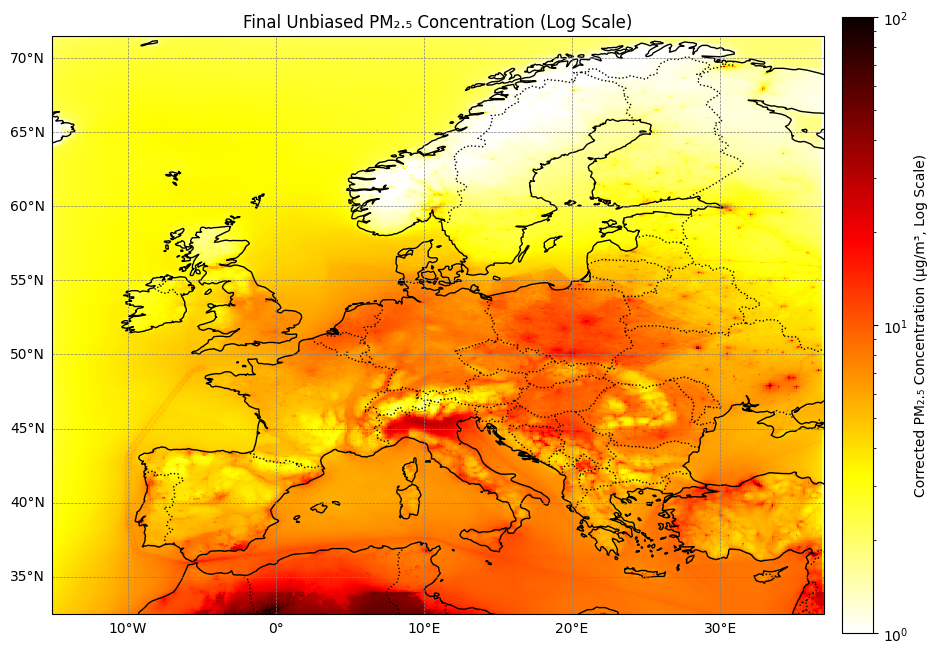

In [29]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import numpy as np

# === Load the Corrected PM₂.₅ NetCDF File ===
corrected_netcdf_path = "Mul/BaseCase_Corrected_PM25_rh50_Y_EXP_MUL.nc"
ds_corrected = xr.open_dataset(corrected_netcdf_path)

# Extract corrected PM₂.₅ values
corrected_pm25 = ds_corrected["SURF_ug_PM25_rh50_corrected"].squeeze().values

# Extract coordinates
lon = ds_corrected["lon"].values
lat = ds_corrected["lat"].values

# Create a 2D meshgrid for lon & lat
Lon, Lat = np.meshgrid(lon, lat)

# === Define Logarithmic Scale for Color Normalization ===
norm = mcolors.LogNorm(vmin=1, vmax=100)  # Log scale between 1 and max value

# Create a figure with a map projection
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the PM₂.₅ concentration using pcolormesh with logarithmic scaling
mesh = ax.pcolormesh(Lon, Lat, corrected_pm25, cmap='hot_r', shading='auto', transform=ccrs.PlateCarree(), norm=norm)

# Add a colorbar with logarithmic scaling
cbar = plt.colorbar(mesh, orientation="vertical", pad=0.02)
cbar.set_label("Corrected PM₂.₅ Concentration (µg/m³, Log Scale)")

# Add coastlines and borders for context
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Add gridlines and labels for longitude and latitude
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Remove top labels
gl.right_labels = False  # Remove right-side labels

# Set title and labels
plt.title("Final Unbiased PM₂.₅ Concentration (Log Scale)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()

# Close dataset
ds_corrected.close()


# Hybrid (HAM)

In [3]:
import numpy as np
import pandas as pd
import netCDF4 as nc
from sklearn.neighbors import BallTree
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import itertools

# === Load CSV Data ===
csv_file_path = "basePM25nearest_grid.csv"
df = pd.read_csv(csv_file_path)

# Compute Additive Bias
df["bias_additive"] = df["SURF_ug_PM25_rh50"] - df["nearest_SURF_ug_PM25_rh50"]

# Compute Multiplicative Bias Ratio
df["bias_ratio"] = df["SURF_ug_PM25_rh50"] / df["nearest_SURF_ug_PM25_rh50"]
df["bias_ratio"] = df["bias_ratio"].replace([np.inf, -np.inf], np.nan)  # Fix inplace warning
df.dropna(subset=["bias_ratio"], inplace=True)

# Load NetCDF Data
netcdf_path = "BaseCase_PERT_PM25_rh50_YEARLY.nc"
dataset = nc.Dataset(netcdf_path, "r")

# Extract Grid Coordinates
lon = dataset.variables["lon"][:]
lat = dataset.variables["lat"][:]
pm25_original = dataset.variables["SURF_ug_PM25_rh50"][0, :, :]

# Compute dynamic transition parameters
T = np.median(pm25_original)  # Transition point = median PM₂.₅
S = (np.percentile(pm25_original, 75) - np.percentile(pm25_original, 25)) / 2  # Slope based on IQR

# Define transition function
def transition_function(pm25, T, S):
    return 1 / (1 + np.exp(- (pm25 - T) / S))

# Create Meshgrid for Grid Points (Convert to Radians)
lon_mesh, lat_mesh = np.meshgrid(lon, lat)
grid_coords = np.column_stack([np.radians(lat_mesh.ravel()), np.radians(lon_mesh.ravel())])

# Prepare Station Data (Convert to Radians)
station_points = np.column_stack([np.radians(df["nearest_grid_lat"].values), np.radians(df["nearest_grid_lon"].values)])
bias_additive_values = df["bias_additive"].values
bias_ratio_values = df["bias_ratio"].values

# Observed PM₂.₅ at station locations
observed_pm25 = df["SURF_ug_PM25_rh50"].values

# Build BallTree using Haversine Distance
tree = BallTree(station_points, metric="haversine")

# === Hyperparameter Optimization (p, k) ===
p_values = np.arange(0.5, 5.1, 0.1).tolist()
k_values = np.arange(2, 41, 1).tolist()

kf = KFold(n_splits=10, shuffle=True, random_state=42)
results = []
best_rmse = float("inf")
best_params = None

with tqdm(total=len(p_values) * len(k_values), desc="Grid Search for Hybrid IDW") as pbar:
    for p, k in itertools.product(p_values, k_values):
        fold_rmses = []

        for train_index, test_index in kf.split(station_points):
            train_points, test_points = station_points[train_index], station_points[test_index]
            train_additive_values = bias_additive_values[train_index]
            train_ratio_values = bias_ratio_values[train_index]

            test_additive_values = bias_additive_values[test_index]
            test_ratio_values = bias_ratio_values[test_index]

            train_tree = BallTree(np.radians(train_points), metric="haversine")

            predicted_bias_hybrid = []

            for test_point in np.radians(test_points):
                dists, idxs = train_tree.query([test_point], k=k)

                if np.any(dists == 0):
                    interpolated_bias = train_additive_values[idxs[0][0]]  # Fix indexing error
                else:
                    weights = np.exp(-p * dists[0])
                    interpolated_additive = np.sum(weights * train_additive_values[idxs[0]]) / np.sum(weights)
                    interpolated_ratio = np.sum(weights * train_ratio_values[idxs[0]]) / np.sum(weights)

                    # Find closest match in PM₂.₅ grid for transition function
                    closest_grid_idx = np.argmin(np.linalg.norm(grid_coords - test_point, axis=1))
                    pm25_value = pm25_original.ravel()[closest_grid_idx]

                    F = transition_function(pm25_value, T, S)

                    interpolated_bias = (1 - F) * interpolated_additive + F * ((interpolated_ratio - 1) * pm25_value)

                predicted_bias_hybrid.append(interpolated_bias)

            fold_rmse = np.sqrt(mean_squared_error(test_additive_values, predicted_bias_hybrid))
            fold_rmses.append(fold_rmse)

        mean_rmse = np.mean(fold_rmses)
        results.append((p, k, mean_rmse))

        if mean_rmse < best_rmse:
            best_rmse = mean_rmse
            best_params = (p, k)

        pbar.update(1)

# Save results
results_df = pd.DataFrame(results, columns=["p", "k", "RMSE"])
results_df.to_csv("BaseCase_PM25_rh50_Y_IDW_HAM_EXP_Val.csv", index=False)

print(f"\n✅ Best parameters found: p={best_params[0]}, k={best_params[1]} with RMSE={best_rmse:.4f}")

# === Apply Hybrid IDW with Optimized Parameters ===
print("\n🚀 Applying Hybrid IDW with Optimized p & k...")
interpolated_bias_hybrid = np.zeros(grid_coords.shape[0])

for i in tqdm(range(grid_coords.shape[0]), desc="Interpolating Hybrid IDW", unit="grid point"):
    dists, idxs = tree.query([grid_coords[i]], k=best_params[1])

    if np.any(dists == 0):
        interpolated_bias_hybrid[i] = bias_additive_values[idxs[0][0]]
    else:
        weights = np.exp(-best_params[0] * dists[0])
        interpolated_additive = np.sum(weights * bias_additive_values[idxs[0]]) / np.sum(weights)
        interpolated_ratio = np.sum(weights * bias_ratio_values[idxs[0]]) / np.sum(weights)

        # Find closest match in PM₂.₅ grid for transition function
        closest_grid_idx = np.argmin(np.linalg.norm(grid_coords - grid_coords[i], axis=1))
        pm25_value = pm25_original.ravel()[closest_grid_idx]

        # Compute transition weight
        F = transition_function(pm25_value, T, S)

        # Smooth Hybrid Correction
        interpolated_bias_hybrid[i] = (1 - F) * interpolated_additive + F * ((interpolated_ratio - 1) * pm25_value)

# Reshape the interpolated bias
interpolated_bias_hybrid = interpolated_bias_hybrid.reshape(pm25_original.shape)

# === Save Bias Correction NetCDF ===
bias_netcdf_path = "BaseCase_PM25_rh50_Y_IDW_EXP_HAM.nc"

new_dataset = nc.Dataset(bias_netcdf_path, "w", format="NETCDF4")
new_dataset.createDimension("lat", lat.shape[0])
new_dataset.createDimension("lon", lon.shape[0])
lat_var = new_dataset.createVariable("lat", "f4", ("lat",))
lon_var = new_dataset.createVariable("lon", "f4", ("lon",))
bias_var = new_dataset.createVariable("Interpolated_Hybrid_Bias", "f4", ("lat", "lon"))

bias_var.setncatts(dataset.variables["SURF_ug_PM25_rh50"].__dict__)
new_dataset.description = "Smoothly Interpolated Bias using Hybrid IDW (Optimized p & k, No Time Dimension)"

lat_var[:] = lat
lon_var[:] = lon
bias_var[:, :] = interpolated_bias_hybrid

new_dataset.close()
print("✅ Hybrid IDW Bias Saved to:", bias_netcdf_path)


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
Grid Search for Hybrid IDW:   0%|          | 2/1794 [02:53<43:10:36, 86.74s/it]


KeyboardInterrupt: 

In [49]:
import numpy as np
import pandas as pd
import netCDF4 as nc
from sklearn.neighbors import BallTree
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import itertools

# === Step 1: Load CSV Data & Compute Bias ===
csv_file_path = "basePM25nearest_grid.csv"
df = pd.read_csv(csv_file_path)

# Compute Additive Bias
df["bias_additive"] = df["SURF_ug_PM25_rh50"] - df["nearest_SURF_ug_PM25_rh50"]

# Compute Multiplicative Bias Ratio
df["bias_ratio"] = df["SURF_ug_PM25_rh50"] / df["nearest_SURF_ug_PM25_rh50"]
df["bias_ratio"].replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(subset=["bias_ratio"], inplace=True)

# === Step 2: Load NetCDF Data ===
netcdf_path = "BaseCase_PERT_PM25_rh50_YEARLY.nc"
dataset = nc.Dataset(netcdf_path, "r")

# Extract Grid Coordinates
lon = dataset.variables["lon"][:]
lat = dataset.variables["lat"][:]
pm25_modeled = dataset.variables["SURF_ug_PM25_rh50"][0, :, :]

# Create Meshgrid for Grid Points
lon_mesh, lat_mesh = np.meshgrid(lon, lat)
grid_coords = np.column_stack([lon_mesh.ravel(), lat_mesh.ravel()])

# Convert coordinates to radians for Haversine distance
grid_coords_rad = np.radians(grid_coords)

# Prepare Station Data
station_points = df[["nearest_grid_lon", "nearest_grid_lat"]].values
bias_additive_values = df["bias_additive"].values
bias_ratio_values = df["bias_ratio"].values

# Convert station coordinates to radians
station_points_rad = np.radians(station_points)

# Build BallTree using Haversine Distance
tree = BallTree(station_points_rad, metric="haversine")

# === Step 3: Hyperparameter Optimization (p, k) ===
p_values = np.arange(0.5, 5.1, 0.1).tolist()
k_values = np.arange(2, 41, 1).tolist()

kf = KFold(n_splits=10, shuffle=True, random_state=42)
results = []
best_rmse = float("inf")
best_params = None

with tqdm(total=len(p_values) * len(k_values), desc="Grid Search for Hybrid IDW") as pbar:
    for p, k in itertools.product(p_values, k_values):
        fold_rmses = []

        for train_index, test_index in kf.split(station_points):
            train_points, test_points = station_points[train_index], station_points[test_index]
            train_additive_values = bias_additive_values[train_index]
            train_ratio_values = bias_ratio_values[train_index]

            test_additive_values = bias_additive_values[test_index]
            test_ratio_values = bias_ratio_values[test_index]

            train_tree = BallTree(np.radians(train_points), metric="haversine")

            predicted_bias_hybrid = []

            for test_point in np.radians(test_points):
                dists, idxs = train_tree.query([test_point], k=k)

                weights = np.exp(-p * dists[0])
                interpolated_additive = np.sum(weights * train_additive_values[idxs[0]]) / np.sum(weights)
                interpolated_ratio = np.sum(weights * train_ratio_values[idxs[0]]) / np.sum(weights)

                predicted_bias_hybrid.append(interpolated_additive)  # Using additive bias for validation

            fold_rmse = np.sqrt(mean_squared_error(test_additive_values, predicted_bias_hybrid))
            fold_rmses.append(fold_rmse)

        mean_rmse = np.mean(fold_rmses)
        results.append((p, k, mean_rmse))

        if mean_rmse < best_rmse:
            best_rmse = mean_rmse
            best_params = (p, k)

        pbar.update(1)

# Save results
results_df = pd.DataFrame(results, columns=["p", "k", "RMSE"])
results_df.to_csv("BaseCase_PM25_rh50_Y_IDW_HAM_EXP_Val.csv", index=False)

print(f"\n Best parameters found: p={best_params[0]}, k={best_params[1]} with RMSE={best_rmse:.4f}")

# === Step 4: Apply Hybrid IDW with Optimized Parameters ===
print("\n Applying Hybrid IDW with Optimized p & k...")
interpolated_bias_additive = np.zeros(grid_coords.shape[0])
interpolated_bias_ratio = np.zeros(grid_coords.shape[0])

for i in tqdm(range(grid_coords.shape[0]), desc="Interpolating Hybrid IDW", unit="grid point"):
    dists, idxs = tree.query([grid_coords_rad[i]], k=best_params[1])

    weights = np.exp(-best_params[0] * dists[0])
    interpolated_bias_additive[i] = np.sum(weights * bias_additive_values[idxs[0]]) / np.sum(weights)
    interpolated_bias_ratio[i] = np.sum(weights * bias_ratio_values[idxs[0]]) / np.sum(weights)

# Reshape the interpolated bias
interpolated_bias_additive = interpolated_bias_additive.reshape(pm25_modeled.shape)
interpolated_bias_ratio = interpolated_bias_ratio.reshape(pm25_modeled.shape)

# === Save Bias Correction NetCDF ===
bias_netcdf_path = "BaseCase_PM25_rh50_Y_IDW_EXP_HAM.nc"

new_dataset = nc.Dataset(bias_netcdf_path, "w", format="NETCDF4")
new_dataset.createDimension("lat", lat.shape[0])
new_dataset.createDimension("lon", lon.shape[0])
lat_var = new_dataset.createVariable("lat", "f4", ("lat",))
lon_var = new_dataset.createVariable("lon", "f4", ("lon",))
bias_add_var = new_dataset.createVariable("Interpolated_Bias_Additive", "f4", ("lat", "lon"))
bias_ratio_var = new_dataset.createVariable("Interpolated_Bias_Ratio", "f4", ("lat", "lon"))

bias_add_var.setncatts(dataset.variables["SURF_ug_PM25_rh50"].__dict__)
bias_ratio_var.setncatts(dataset.variables["SURF_ug_PM25_rh50"].__dict__)

lat_var[:] = lat
lon_var[:] = lon
bias_add_var[:, :] = interpolated_bias_additive
bias_ratio_var[:, :] = interpolated_bias_ratio

new_dataset.close()
print(" Hybrid IDW Bias Saved to:", bias_netcdf_path)

# === Step 5: Apply Blended Hybrid Correction ===
corrected_nc_path = "BaseCase_Corrected_PM25_rh50_Y_EXP_HAM.nc"

with nc.Dataset(original_nc_path, "r") as original_nc, nc.Dataset(bias_netcdf_path, "r") as bias_nc:

    pm25_original = original_nc.variables["SURF_ug_PM25_rh50"][:]
    interpolated_bias_additive = bias_nc.variables["Interpolated_Bias_Additive"][:]
    interpolated_bias_ratio = bias_nc.variables["Interpolated_Bias_Ratio"][:]

    T = 5.0  # Transition point
    S = 2.0  # Slope factor

    lambda_blend = 1 / (1 + np.exp((pm25_original - T) / S))

    pm25_corrected = (
        lambda_blend * (pm25_original + interpolated_bias_additive) +
        (1 - lambda_blend) * (pm25_original * interpolated_bias_ratio)
    )

    with nc.Dataset(corrected_nc_path, "w", format="NETCDF4") as new_nc:
        new_nc.createDimension("time", None)
        new_nc.createDimension("lat", lat.shape[0])
        new_nc.createDimension("lon", lon.shape[0])
        pm25_var = new_nc.createVariable("SURF_ug_PM25_rh50_corrected", "f4", ("time", "lat", "lon"))
        pm25_var[:] = pm25_corrected

print(" Blended Hybrid Bias Correction Completed Successfully!")
print(" Corrected PM₂.₅ NetCDF file saved as:", corrected_nc_path)


<ipython-input-49-548d9acdc95e>:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["bias_ratio"].replace([np.inf, -np.inf], np.nan, inplace=True)
Grid Search for Hybrid IDW:   1%|▏         | 23/1794 [00:10<13:01,  2.27it/s]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



<ipython-input-46-fec196591dba>:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.2, 1, 0.95])  # Leave space for colorbars at the bottom


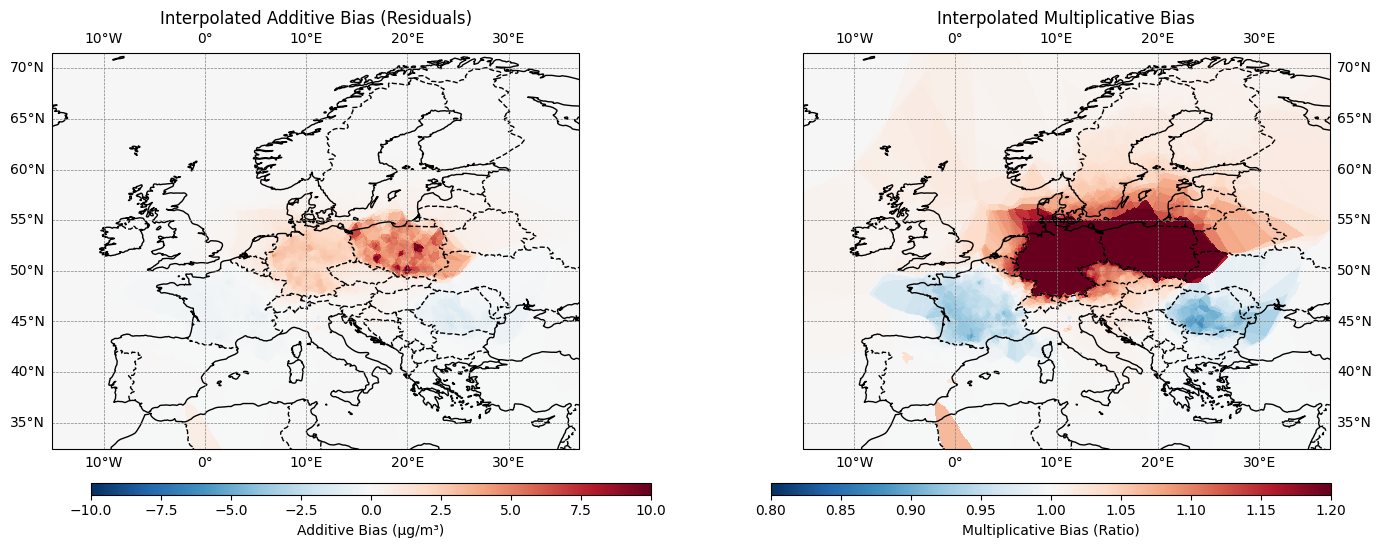

In [46]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# === Load the Interpolated Bias NetCDF File ===
bias_netcdf_path = "BaseCase_PM25_rh50_Y_IDW_EXP_HAM.nc"
ds_bias = xr.open_dataset(bias_netcdf_path)

# Extract interpolated biases
interpolated_additive_bias = ds_bias["Interpolated_Bias_Additive"].squeeze().values
interpolated_multiplicative_bias = ds_bias["Interpolated_Bias_Ratio"].squeeze().values

# Extract coordinates
lon = ds_bias["lon"].values
lat = ds_bias["lat"].values

# === Define Plot Limits ===
additive_cbar_min, additive_cbar_max = -10, 10  # Additive bias range
multiplicative_cbar_min, multiplicative_cbar_max = 0.8, 1.2  # Multiplicative bias range

# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# === Plot Additive Bias ===
ax1 = axes[0]
im1 = ax1.pcolormesh(lon, lat, interpolated_additive_bias, transform=ccrs.PlateCarree(),
                     cmap="RdBu_r", vmin=additive_cbar_min, vmax=additive_cbar_max, shading='auto')

ax1.set_title("Interpolated Additive Bias (Residuals)")
ax1.add_feature(cfeature.BORDERS, linestyle="--", edgecolor="black", linewidth=1)
ax1.coastlines(resolution="50m", linewidth=1)
gl1 = ax1.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl1.right_labels = False  # Avoid overlapping labels on the right

# === Plot Multiplicative Bias ===
ax2 = axes[1]
im2 = ax2.pcolormesh(lon, lat, interpolated_multiplicative_bias, transform=ccrs.PlateCarree(),
                     cmap="RdBu_r", vmin=multiplicative_cbar_min, vmax=multiplicative_cbar_max, shading='auto')

ax2.set_title("Interpolated Multiplicative Bias")
ax2.add_feature(cfeature.BORDERS, linestyle="--", edgecolor="black", linewidth=1)
ax2.coastlines(resolution="50m", linewidth=1)
gl2 = ax2.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl2.left_labels = False  # Avoid overlapping labels on the left

# === Add Shared Colorbars ===
# Additive Bias Colorbar
cbar_ax1 = fig.add_axes([0.125, 0.15, 0.35, 0.02])  # [left, bottom, width, height]
cbar1 = fig.colorbar(im1, cax=cbar_ax1, orientation="horizontal")
cbar1.set_label("Additive Bias (µg/m³)")

# Multiplicative Bias Colorbar
cbar_ax2 = fig.add_axes([0.55, 0.15, 0.35, 0.02])  # [left, bottom, width, height]
cbar2 = fig.colorbar(im2, cax=cbar_ax2, orientation="horizontal")
cbar2.set_label("Multiplicative Bias (Ratio)")

# Adjust layout and show the plot
plt.tight_layout(rect=[0, 0.2, 1, 0.95])  # Leave space for colorbars at the bottom
plt.show()

# Close dataset
ds_bias.close()


In [44]:
import netCDF4 as nc
import numpy as np

# === Define File Paths ===
original_nc_path = "BaseCase_PERT_PM25_rh50_YEARLY.nc"
bias_nc_path = "BaseCase_PM25_rh50_Y_IDW_EXP_HAM.nc"
corrected_nc_path = "BaseCase_Corrected_PM25_rh50_Y_EXP_HAM.nc"

# Define Threshold for Switching Between Additive & Multiplicative Correction
threshold = 5.0  # Example: PM2.5 below 5 µg/m³ → Additive, above → Multiplicative

# === Load NetCDF Data ===
with nc.Dataset(original_nc_path, "r") as original_nc, nc.Dataset(bias_nc_path, "r") as bias_nc:
    lon = original_nc.variables["lon"][:]
    lat = original_nc.variables["lat"][:]
    time = original_nc.variables["time"][:]
    pm25_original = original_nc.variables["SURF_ug_PM25_rh50"][:]  # Original PM2.5 data

    # Load interpolated bias data
    interpolated_additive_bias = bias_nc.variables["Interpolated_Bias_Additive"][:]  # Additive bias
    interpolated_multiplicative_bias = bias_nc.variables["Interpolated_Bias_Ratio"][:]  # Multiplicative bias

    # Apply Hybrid Bias Correction
    pm25_corrected = np.where(
        pm25_original < threshold,
        pm25_original + interpolated_additive_bias,  # Additive Correction
        pm25_original * interpolated_multiplicative_bias  # Multiplicative Correction
    )

# === Save the Corrected PM₂.₅ to a New NetCDF File ===
with nc.Dataset(corrected_nc_path, "w", format="NETCDF4") as new_nc:
    # Create dimensions
    new_nc.createDimension("time", None)
    new_nc.createDimension("lat", lat.shape[0])
    new_nc.createDimension("lon", lon.shape[0])

    # Create variables
    time_var = new_nc.createVariable("time", "f4", ("time",))
    lat_var = new_nc.createVariable("lat", "f4", ("lat",))
    lon_var = new_nc.createVariable("lon", "f4", ("lon",))
    pm25_var = new_nc.createVariable("SURF_ug_PM25_rh50_corrected", "f4", ("time", "lat", "lon"), fill_value=-9999.0)

    # Copy attributes from the original PM₂.₅ variable
    pm25_var.setncatts(original_nc.variables["SURF_ug_PM25_rh50"].__dict__)

    # Save data
    time_var[:] = time
    lat_var[:] = lat
    lon_var[:] = lon
    pm25_var[:] = pm25_corrected  # Store corrected PM₂.₅

print(" Hybrid Bias Correction Completed Successfully!")
print(" Corrected PM₂.₅ NetCDF file saved as:", corrected_nc_path)


 Hybrid Bias Correction Completed Successfully!
 Corrected PM₂.₅ NetCDF file saved as: BaseCase_Corrected_PM25_rh50_Y_EXP_HAM.nc


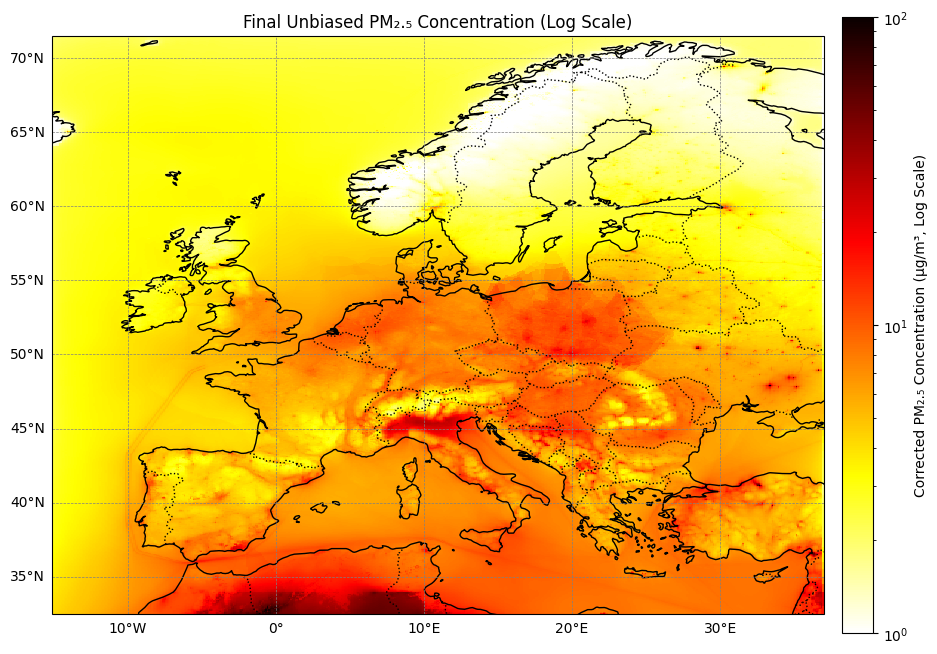

In [45]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import numpy as np

# === Load the Corrected PM₂.₅ NetCDF File ===
corrected_netcdf_path = "BaseCase_Corrected_PM25_rh50_Y_EXP_HAM.nc"
ds_corrected = xr.open_dataset(corrected_netcdf_path)

# Extract corrected PM₂.₅ values
corrected_pm25 = ds_corrected["SURF_ug_PM25_rh50_corrected"].squeeze().values

# Extract coordinates
lon = ds_corrected["lon"].values
lat = ds_corrected["lat"].values

# Create a 2D meshgrid for lon & lat
Lon, Lat = np.meshgrid(lon, lat)

# === Define Logarithmic Scale for Color Normalization ===
norm = mcolors.LogNorm(vmin=1, vmax=100)  # Log scale between 1 and max value

# Create a figure with a map projection
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the PM₂.₅ concentration using pcolormesh with logarithmic scaling
mesh = ax.pcolormesh(Lon, Lat, corrected_pm25, cmap='hot_r', shading='auto', transform=ccrs.PlateCarree(), norm=norm)

# Add a colorbar with logarithmic scaling
cbar = plt.colorbar(mesh, orientation="vertical", pad=0.02)
cbar.set_label("Corrected PM₂.₅ Concentration (µg/m³, Log Scale)")

# Add coastlines and borders for context
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Add gridlines and labels for longitude and latitude
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Remove top labels
gl.right_labels = False  # Remove right-side labels

# Set title and labels
plt.title("Final Unbiased PM₂.₅ Concentration (Log Scale)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()

# Close dataset
ds_corrected.close()
